# Validation Service Benchmarks


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv("sh13rs_gisjoins_vs/0-lattice-100.nmon.csv", header=0)
df

,timestamp,CPU_ALL:User%,MEM:memtotal,MEM:active,MEM:inactive,NET:eno1-write-KB/s,NET:eno1-read-KB/s
0,1646050497,27.4,31829.2,10161.7,15311.7,291.5,466.1
1,1646050498,11.9,31829.2,10161.5,15144.3,13.2,15.1
2,1646050499,5.8,31829.2,10161.5,15143.6,3.5,10.9
3,1646050500,5.8,31829.2,10161.5,15143.8,1.5,6.5
4,1646050501,4.2,31829.2,10161.5,15153.6,12.1,20.9
...,...,...,...,...,...,...,...
76,1646050573,3.4,31829.2,10161.6,15160.9,11.5,7.3
77,1646050574,6.2,31829.2,10161.6,15161.3,2.6,9.6
78,1646050575,5.1,31829.2,10161.6,15186.3,12.5,44.1
79,1646050576,5.2,31829.2,10161.6,15210.8,4.5,29.4


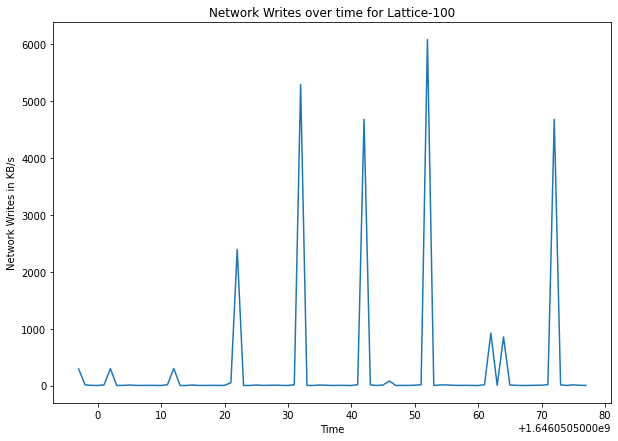

In [9]:

plt.figure(figsize=(10,7))   # Set the size of your plot. It will determine the relative size of all the labels.
plt.plot(df['timestamp'], df['NET:eno1-write-KB/s'], label="Network Write, KB/s") # Plot a curve.
#plt.plot(df['timestamp'], df['CPU_ALL:User%'], label="Network Write, KB/s") # Plot a curve.
plt.xlabel("Time")
plt.ylabel("Network Writes in KB/s")
plt.title("Network Writes over time for Lattice-100")
plt.show()